In [76]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import milopy
import milopy.core as milo
import milopy.plot as milopl
import milopy.utils

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [77]:
adata = sc.read("/home/h/hollenberg/MaPra/adata_annotated.h5ad")
adata = adata[adata.obs.condition != "nintedanib"]
adata

View of AnnData object with n_obs × n_vars = 12648 × 18252
    obs: 'samples', 'GSM', 'condition', 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'is_doublet', 'leiden', 'manual_celltype_annotation_coarse', 'manual_celltype_annotation_precise'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'condition_colors', 'is_doublet_colors', 'leiden', 'leiden_colors', 'manual_celltype_annotation_coarse_colors', 'manual_celltype_annotation_precise_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'samples_colors', 'scrublet', 'u

In [78]:
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)

In [79]:
milo.make_nhoods(adata, prop=0.1)
adata.obsm["nhoods"]
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
AAACCTGCATAACCTG-1,1,3.894334
AAAGATGGTGCCTTGG-1,1,11.082984
AACCATGTCACCATAG-1,1,5.065373
AACGTTGCACACAGAG-1,1,3.813080
AACTCCCAGGATGCGT-1,1,6.811594
...,...,...
TGCTACCGTAGCCTAT-1-1,1,7.556916
TGGCTGGCAGGGAGAG-1,1,8.021644
TGTGTTTTCAGTTGAC-1,1,7.333004
TTAGTTCTCAGTCAGT-1,1,10.131394


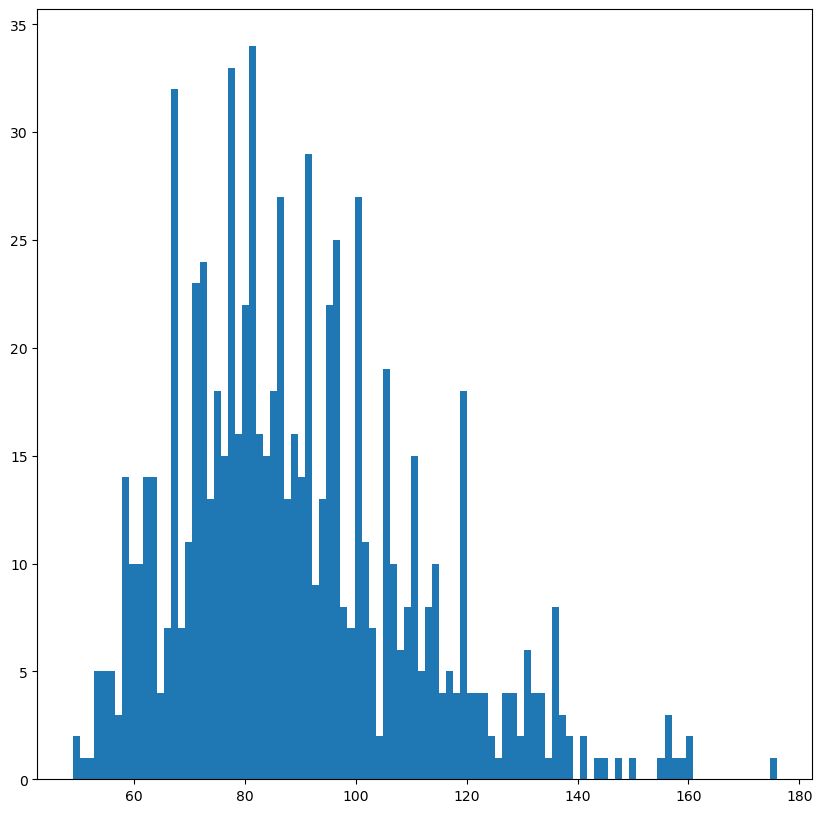

In [80]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [81]:
milo.count_nhoods(adata, sample_col="samples")
adata.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 802 × 8
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [82]:
adata.obs["condition_continuous"] = adata.obs["condition"].cat.codes
milo.DA_nhoods(adata, design="~condition_continuous")

In [83]:
adata.uns["nhood_adata"].obs

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,AAACCTGCATAACCTG-1,3.894334,0.163820,10.381945,0.015531,0.902701,0.940216,0.949359
1,AAAGATGGTGCCTTGG-1,11.082984,4.000921,10.499826,6.752058,0.021852,0.092725,0.103097
2,AACCATGTCACCATAG-1,5.065373,0.153835,10.161314,0.014652,0.905486,0.941404,0.950448
3,AACGTTGCACACAGAG-1,3.813080,0.948425,10.470195,0.419187,0.528486,0.698263,0.743300
4,AACTCCCAGGATGCGT-1,6.811594,0.825352,10.347127,0.427752,0.524169,0.698263,0.743300
...,...,...,...,...,...,...,...,...
797,TGCTACCGTAGCCTAT-1-1,7.556916,-0.941991,10.150598,0.800218,0.386704,0.585163,0.634305
798,TGGCTGGCAGGGAGAG-1,8.021644,5.108321,10.425476,6.229194,0.026619,0.100088,0.108892
799,TGTGTTTTCAGTTGAC-1,7.333004,5.344396,10.626707,6.391983,0.025034,0.098063,0.106400
800,TTAGTTCTCAGTCAGT-1,10.131394,1.276568,10.216429,1.045309,0.324568,0.530914,0.575140


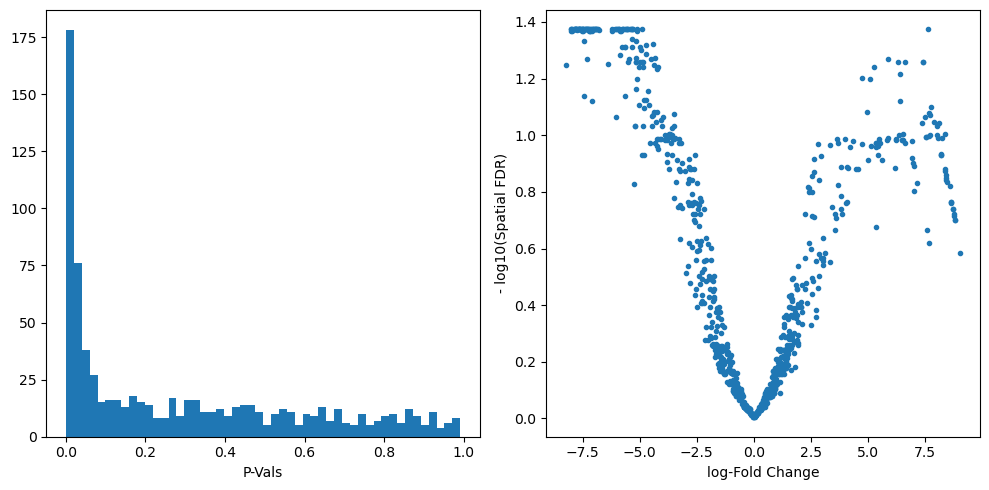

In [84]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [85]:
milopy.utils.build_nhood_graph(adata)

In [89]:
nhood_adata = adata.uns["nhood_adata"].copy()
nhood_adata

AnnData object with n_obs × n_vars = 802 × 8
    obs: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Nhood_size'
    var: 'condition_continuous', 'samples'
    uns: 'sample_col', 'nhood'
    obsm: 'X_milo_graph'
    obsp: 'nhood_connectivities'

In [98]:
alpha=0.01
min_size=2 
min_logFC = 0
title = "DA log-Fold Change"

In [95]:
nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"]
                        > alpha, "graph_color"] = np.nan
nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"]
                        < min_logFC, "graph_color"] = np.nan

# Plotting order - extreme logFC on top
nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(),
                        "abs_logFC"] = np.nan
ordered = nhood_adata.obs.sort_values(
        'abs_logFC', na_position='first').index
nhood_adata = nhood_adata[ordered]

vmax = np.max([nhood_adata.obs["graph_color"].max(),
                  abs(nhood_adata.obs["graph_color"].min())])
vmin = - vmax

In [102]:
adata.uns["nhood_adata"].obs["Nhood_size"]*min_size

0      194.0
1      128.0
2      170.0
3      226.0
4      180.0
       ...  
797    132.0
798    116.0
799    136.0
800    142.0
801    258.0
Name: Nhood_size, Length: 802, dtype: float32

In [106]:
print(nhood_adata.X)

  (644, 0)	1.0
  (595, 0)	1.0
  (144, 0)	1.0
  (629, 0)	1.0
  (780, 0)	1.0
  (287, 0)	1.0
  (597, 0)	1.0
  (186, 0)	1.0
  (158, 0)	1.0
  (669, 0)	2.0
  (439, 0)	2.0
  (224, 0)	1.0
  (776, 0)	3.0
  (633, 0)	1.0
  (570, 0)	1.0
  (520, 0)	1.0
  (602, 0)	1.0
  (166, 0)	3.0
  (290, 0)	1.0
  (587, 0)	1.0
  (739, 0)	1.0
  (594, 0)	1.0
  (485, 0)	1.0
  (671, 0)	3.0
  (636, 0)	3.0
  :	:
  (210, 7)	16.0
  (185, 7)	41.0
  (8, 7)	6.0
  (785, 7)	34.0
  (762, 7)	61.0
  (417, 7)	59.0
  (399, 7)	39.0
  (22, 7)	5.0
  (279, 7)	29.0
  (81, 7)	5.0
  (79, 7)	3.0
  (13, 7)	16.0
  (743, 7)	21.0
  (681, 7)	14.0
  (433, 7)	28.0
  (233, 7)	36.0
  (755, 7)	33.0
  (652, 7)	25.0
  (621, 7)	15.0
  (420, 7)	29.0
  (194, 7)	24.0
  (757, 7)	61.0
  (754, 7)	67.0
  (751, 7)	69.0
  (742, 7)	78.0


StopIteration: 

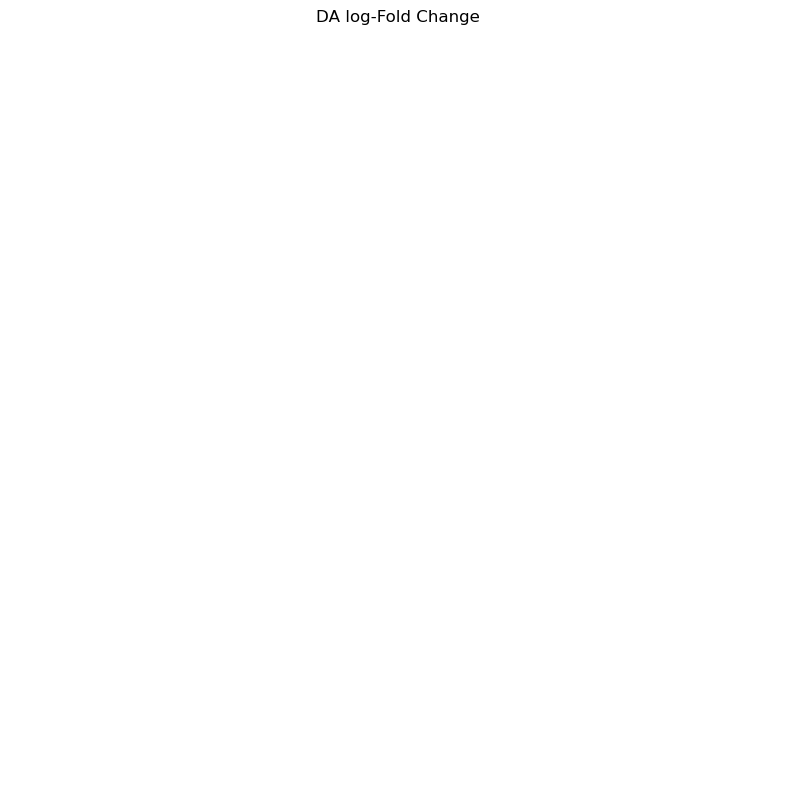

In [100]:
sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", cmap="RdBu_r",
                    size=adata.uns["nhood_adata"].obs["Nhood_size"]*min_size,
                    edges=False, neighbors_key="nhood",
                    # edge_width =
                    sort_order=False,
                    frameon=False,
                    vmax=vmax, vmin=vmin,
                    title=title#,**kwargs
                    )

StopIteration: 

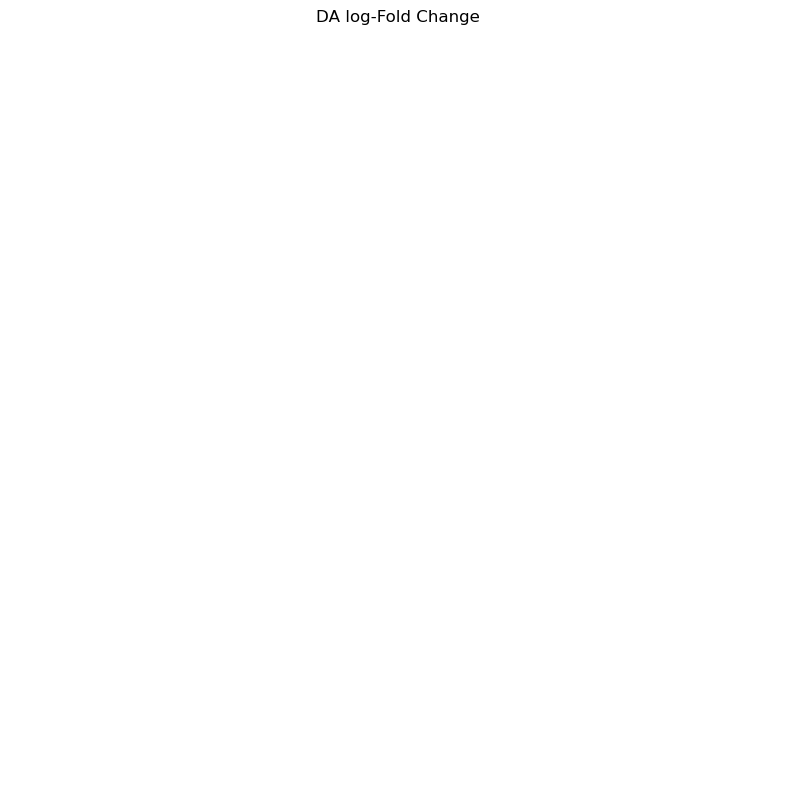

In [86]:
#import milopy.utils 
plt.rcParams["figure.figsize"] = [10,10]
milopl.plot_nhood_graph(adata,
alpha=0.01, ## SpatialFDR level (1%)
min_size=2 ## Size of smallest dot 
                       )

In [ ]:
#adata_scvi = adata[:, adata.var["highly_variable"]].copy()
#scvi.model.SCVI.setup_anndata(adata_scvi, layer="log1p_norm", batch_key="condition")
#model_scvi = scvi.model.SCVI(adata_scvi)
#max_epochs_scvi = int(np.min([round((200 / adata.n_obs) * 400), 50]))
#model_scvi.train(max_epochs=max_epochs_scvi)
#adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [ ]:
sc.pp.neighbors(mdata['rna'], use_rep='X_scVI', n_neighbors=150, n_pcs=10)
